In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack, stats
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

#### Functions

In [9]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [10]:
def get_responsive_pvalue(spike_times, spike_clusters, unit_ids, events, response_window=[0.002, 0.1], apply_mc_corr=True):
    wstat = np.zeros(len(unit_ids), dtype=float) * np.nan
    pvals = np.zeros(len(unit_ids), dtype=float) * np.nan
    spcounts = np.zeros(len(unit_ids), dtype=float) * np.nan
    
    for indi, uniti in enumerate(unit_ids):
        spikesi = np.squeeze(spike_times[spike_clusters == uniti])

        pre_spcounts = np.zeros(len(events), dtype=int)
        post_spcounts = np.zeros(len(events), dtype=int)
        for j, E in enumerate(events):
            pre_spcounts[j] = np.sum((spikesi >= E-response_window[1]) & (spikesi <= E-response_window[0]))
            post_spcounts[j] = np.sum((spikesi >= E+response_window[0]) & (spikesi <= E+response_window[1]))
        
#         if (post_spcounts - pre_spcounts).any():
            # stats.wilcoxon tests whether the differences x-y is symmetric about zero #
        wstat[indi], pvals[indi] = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
            # added zero-method as zsplit because many of the units have too few non-zero samples #
            # this includes the zeros in ranking, but splits them evenly between positive and negative difference ranks #
        spcounts[indi] = np.mean(post_spcounts) - np.mean(pre_spcounts)
        
    if apply_mc_corr:
#         print('Applying multiple comparisons correction...')
        rej, pvals = multitest.fdrcorrection(pvals) #, alpha=0.01) # default alpha=0.05

    return pvals, spcounts

### Define data path

In [11]:
rec_folder = r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.


In [12]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim2


#### Load stim table and speed signal

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good
0,biphasic,40,0.0004,319.16422,319.16462,0,True
1,biphasic,20,0.0004,322.69724,322.69764,0,True
2,biphasic,40,0.0004,326.75887,326.75927,0,True
3,biphasic,60,0.0004,331.14116,331.14156,0,True
4,biphasic,60,0.0004,335.31077,335.31117,0,True


In [28]:
state_sweeps = {'awake': [0], 'anesthetized': [3]}#, 'recovery1': [2]}

In [15]:
run_signal, run_timestamps = exp.load_running()

In [16]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
        
## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(currents_list)
print(PCI_stim_amp)

['20', '40', '60']
40


#### Load unit data

In [17]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [19]:
## List probes: region labels in order from top to bottom ##
regions = {'probeF': 'ACA <-> MOs', 'probeB': 'VM <-> SSp', 'probeC': 'LGN <-> VIS'}
# regions = {'probeB': 'ACA <---> MOs'}#, 'probeC': 'V1/LGN'}
# regions = {'probeF': 'MOs', 'probeB': 'VM/VAL', 'probeD': 'V1/LGN'}

In [20]:
FR_threshold = None # only chooses units with firing rate above this frequency, if None does not apply threshold

In [21]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    
    ## Apply firing rate threshold ##
    if FR_threshold != None:
        unit_metrics = unit_metrics[unit_metrics['firing_rate'] > FR_threshold]
        select_units = unit_metrics.cluster_id.values
        peak_chs = unit_metrics.peak_channel.values
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['units'] = all_units
    probe_unit_data[probei]['chs'] = all_units_chs
    probe_unit_data[probei]['cell_type'] = all_units_types
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['areas'] = all_units_areas
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 340
 unit count: 218
probeC
 surface channel: 350
 unit count: 343
probeF
 surface channel: 285
 unit count: 298
Total unit count: 859


### Count responsive units

In [22]:
rest_trials_only = True

## Responsive parameters ##
spcount_window = [0.002, 0.025] # [0.002, 0.025] [0.025, 0.125]
alpha = 0.05

In [29]:
all_event_times = {}
for parami in currents_list:
    print('biphasic - {} \u03bcA'.format(parami))
    all_event_times[parami] = {}
    for statei, sweeps in state_sweeps.items():
        ## Get all event times for statei ##
        state_events = []
        for sweepi in sweeps:
            events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
            if len(events) == 0:
                continue
            state_events.append(events)
        state_events = np.concatenate(state_events)

        ## Get mean speed for all events ##
        rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
        event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
        mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
        rest_events = np.nonzero(mean_speed == 0)[0]
        print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

        if rest_trials_only:
            all_event_times[parami][statei] = state_events[rest_events]
        else:
            all_event_times[parami][statei] = state_events

biphasic - 20 μA
 awake state: resting trials 90/112
 anesthetized state: resting trials 120/120
biphasic - 40 μA
 awake state: resting trials 89/110
 anesthetized state: resting trials 119/119
biphasic - 60 μA
 awake state: resting trials 94/115
 anesthetized state: resting trials 120/120


In [30]:
unit_responses = {}
for parami, statesevents in all_event_times.items():
    unit_responses[parami] = {}
    for statei, events in statesevents.items():
        
        ## Loop through probes to get unit responsiveness ##
        units_list = []
        areas_list = []
        parents_list = []
        types_list = []
        response_list = []
        for probei, unit_data in probe_unit_data.items():
            unit_ids = [probei[-1] + str(x) for x in unit_data['units']]
            unit_pvals, unit_spcounts = get_responsive_pvalue(
                unit_data['spike_times'],
                unit_data['spike_clusters'],
                unit_data['units'],
                events,
                spcount_window,
        #         apply_mc_corr=False, # default = True
            )
        
            ## Loop through all units and add to the correct population ##
            probe_parent_list = []
            probe_response_list = []
            for unitind in range(unit_pvals.shape[0]):
                parent_region = [
                    key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]
                ]
                if unit_pvals[unitind] < alpha and unit_spcounts[unitind] > 0:
                    probe_response_list.append('excited')
                elif unit_pvals[unitind] < alpha and unit_spcounts[unitind] < 0:
                    probe_response_list.append('inhibited')
                else:
                    probe_response_list.append('ns')
                if len(parent_region) == 1:
                    probe_parent_list.append(parent_region[0])
                else:
                    probe_parent_list.append('none')
                    
            units_list.append(unit_ids)
            areas_list.append(unit_data['areas'])
            parents_list.append(probe_parent_list)
            types_list.append(unit_data['cell_type'])
            response_list.append(probe_response_list)
            
        ## Make a dataframe with all of the unit data
        unit_responses[parami][statei] = pd.DataFrame({
                'unit_id': np.concatenate(units_list),
                'area': np.concatenate(areas_list),
                'parent': np.concatenate(parents_list),
                'cell_type': np.concatenate(types_list),
                'response': np.concatenate(response_list),
            })

Bar plot parameters

In [26]:
x = np.arange(len(areas_of_interest.keys()))  # the label locations
width = 1/8  # the width of the bars
barlocs = width * ((np.arange(len(currents_list)*len(state_sweeps))-1) - len(currents_list)*len(state_sweeps)/4)
barcolors = ['lightblue', 'dodgerblue', 'blue']
state_hatch = [None, 'xxx']

Plot number of responsive units by type

<IPython.core.display.Javascript object>


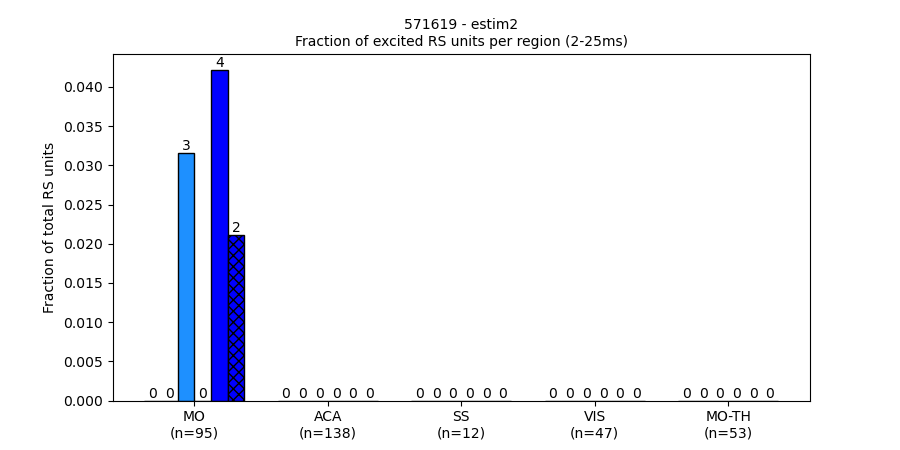

In [31]:
plot_cell_type = 'RS'
plot_response_type = 'excited'

labels = []
fig, ax = plt.subplots(figsize=(9,4.5))
for ii, region in enumerate(areas_of_interest.keys()):
    for jj, (parami, state_uresp) in enumerate(unit_responses.items()):
        for kk, (statei, unit_df) in enumerate(state_uresp.items()):
            count_series = unit_df.groupby(['parent', 'cell_type', 'response']).size()
            try:
                unit_total = count_series[region][plot_cell_type].sum()
                try:
                    resp_count = count_series[region][plot_cell_type][plot_response_type]
                    resp_fraction = resp_count / unit_total
                except KeyError:
                    resp_count = 0
                    resp_fraction = 0
            except KeyError:
                unit_total = 0
                resp_count = 0
                resp_fraction = 0
            rect = ax.bar(
                x[ii] + barlocs[jj*2+kk], resp_fraction, width, color=barcolors[jj], edgecolor='k', hatch=state_hatch[kk]
            )
            ax.text(
                rect[0].get_x() + rect[0].get_width() / 2, rect[0].get_height(),
                '{:d}'.format(resp_count), ha='center', va='bottom', fontsize=10
            )
    labels.append('{}\n(n={:d})'.format(region, unit_total))
            
ax.set_ylabel('Fraction of total {} units'.format(plot_cell_type))
ax.set_title('{} - {}\nFraction of {} {} units per region ({:d}-{:d}ms)'.format(
    exp.mouse, exp_tag, plot_response_type, plot_cell_type, int(spcount_window[0]*1E3), int(spcount_window[1]*1E3)))
ax.set_xticks(x)
ax.set_xticklabels(labels)

## Save ##
figname = '{}_{}-{}units_{:d}-{:d}ms.png'.format(
    exp_tag, plot_response_type, plot_cell_type, int(spcount_window[0]*1E3), int(spcount_window[1]*1E3))
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

### Make a raster plots for all units for all trial types.

Make individual raster plot

### Get evoked responsiveness and baseline responsiveness